In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import ndcg_score

In [4]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/Top50Dest_Searched_100KrowsNaHandled.parquet')

In [5]:
df.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,checkin_day,checkout_day
0,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,1,1,4.0,1625.0,5.0,0,0,5.0,0,0,0.0,2,2
1,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,2,1,4.0,275.0,4.0,1,1,4.0,0,0,0.0,2,2
2,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,3,1,4.0,1275.0,5.0,1,0,4.0,0,0,0.0,2,2
3,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,4,1,5.0,1250.0,5.0,1,1,5.0,0,0,0.0,2,2
4,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,5,0,4.0,5200.0,5.0,1,1,5.0,0,0,1.0,2,2


## Computing NDCG without ADS

In [6]:
df_noad = df[df['is_travel_ad'] == 0]
df_noad.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,checkin_day,checkout_day
4,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,5,0,4.0,5200.0,5.0,1,1,5.0,0,0,1.0,2,2
5,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,6,0,4.0,2875.0,5.0,1,1,5.0,0,0,2.0,2,2
6,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,7,0,5.0,1250.0,5.0,1,1,5.0,0,0,3.0,2,2
7,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,8,0,4.0,2075.0,4.0,1,1,4.0,0,0,4.0,2,2
8,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,9,0,4.0,1100.0,5.0,0,1,2.0,0,0,5.0,2,2


In [7]:
df_noad.shape

(521371, 31)

In [8]:
df_m = df_noad.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

no_s_id = df_m[df_m['num_clicks'] != 0]['search_id'].tolist()

df_noad = df_noad[df_noad['search_id'].isin(no_s_id)]
df_noad.shape

(59615, 31)

In [9]:
#Assigning +1 per each click and +2 per booking, having as max value 3
df_noad['relevance'] = df_noad['num_clicks'] + 2 * df_noad['is_trans']
df_noad.loc[df_noad['relevance'] > 3, 'relevance'] = 3
df_noad['relevance'].value_counts()

<ipython-input-9-f9a04d572cbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noad['relevance'] = df_noad['num_clicks'] + 2 * df_noad['is_trans']


relevance
0    55652
1     3281
3      438
2      244
Name: count, dtype: int64

In [10]:
def split_by_qid(df2, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df2['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df2[df2['search_id'].isin(ids[train_idx])], df2[df2['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df_noad, test_size=0.2)

train_df.shape, test_df.shape

((47731, 32), (11884, 32))

In [11]:
train_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'is_travel_ad'], inplace=True)
test_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'is_travel_ad'], inplace=True)

train_df.shape, test_df.shape

<ipython-input-11-686441a75585>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'is_travel_ad'], inplace=True)
<ipython-input-11-686441a75585>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'is_travel_ad'], inplace=True)


((47731, 23), (11884, 23))

In [12]:
X_train = train_df.drop(columns=['relevance'])
y_train = train_df['relevance']

X_test = test_df.drop(columns=['relevance'])
y_test = test_df['relevance']

query_id_train = X_train['search_id']

query_id_test = X_test['search_id']

In [13]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

numeric_features.remove('search_id')

categorical_features, numeric_features

(['sort_type', 'star_rating', 'price_bucket'],
 ['point_of_sale',
  'geo_location_country',
  'is_mobile',
  'destination_id',
  'adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'search_day_of_week',
  'search_hour_of_day',
  'review_rating',
  'review_count',
  'is_free_cancellation',
  'is_drr',
  'checkin_day',
  'checkout_day'])

In [14]:
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [15]:
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)
X_train.shape, X_test.shape

((47731, 40), (11884, 40))

In [16]:
X_train_2 = X_train.drop(columns=['search_id'])
X_train_2.head()

,point_of_sale,geo_location_country,is_mobile,destination_id,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,review_rating,review_count,is_free_cancellation,is_drr,checkin_day,checkout_day,sort_type_DEALS,sort_type_GUEST RATINGS DESCENDING,sort_type_PRICE ASCENDING,sort_type_RECOMMENDED,sort_type_SPECIAL - DIRECT HOTEL SEARCH,sort_type_STAR RATING DESCENDING,sort_type_VACATION RENTAL,star_rating_0,star_rating_1.0,star_rating_2.0,star_rating_3.0,star_rating_4.0,star_rating_5.0,star_rating_Not Available,price_bucket_0,price_bucket_1.0,price_bucket_2.0,price_bucket_3.0,price_bucket_4.0,price_bucket_5.0,price_bucket_Not Available
213,-0.281569,-0.22063,1.04749,1.306371,-0.208079,-0.34613,0.0,0.0,-0.101802,-0.120458,0.128649,0.077692,0.035466,-0.289651,-1.534357,-1.344571,-0.557594,-0.557594,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
216,-0.281569,-0.22063,1.04749,1.306371,-0.208079,-0.34613,0.0,0.0,-0.101802,-0.120458,0.128649,0.077692,0.035466,0.011796,0.651739,0.743732,-0.557594,-0.557594,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
217,-0.281569,-0.22063,1.04749,1.306371,-0.208079,-0.34613,0.0,0.0,-0.101802,-0.120458,0.128649,0.077692,0.035466,-0.334548,0.651739,0.743732,-0.557594,-0.557594,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
218,-0.281569,-0.22063,1.04749,1.306371,-0.208079,-0.34613,0.0,0.0,-0.101802,-0.120458,0.128649,0.077692,1.030080,-0.110065,0.651739,0.743732,-0.557594,-0.557594,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
219,-0.281569,-0.22063,1.04749,1.306371,-0.208079,-0.34613,0.0,0.0,-0.101802,-0.120458,0.128649,0.077692,0.035466,-0.296065,0.651739,0.743732,-0.557594,-0.557594,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False


In [17]:
import lightgbm as lgb

X_train_arr = X_train_2.values

y_train_array = y_train.values.ravel()

query_group_sizes_train = []
for i in X_train['search_id'].value_counts():
  query_group_sizes_train.append(i)

query_group_sizes_train_arr = np.array(query_group_sizes_train)

# Define LightGBM parameters for ranker
params = {
    'objective': 'lambdarank',  # Ranking objective
    'metric': 'ndcg',  # Evaluation metric
    'learning_rate': 0.01,
    'verbose': 0
}

train_data = lgb.Dataset(X_train_arr, label=y_train_array, group=query_group_sizes_train_arr)

num_rounds = 1000
ranker_model = lgb.train(params, train_data, num_rounds)

In [18]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values

y_test_array = y_test.values.ravel()

query_group_sizes_test = []
for i in X_test['search_id'].value_counts():
  query_group_sizes_test.append(i)
query_group_sizes_test_arr = np.array(query_group_sizes_test)

test_data = lgb.Dataset(X_test_arr, label=y_test_array, group=query_group_sizes_test_arr, reference=train_data)

In [19]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': test_predictions})
y_test_df.head()

,relevance_score,predicted_ranking
4566,3,-0.000904
4569,0,-0.337159
4570,0,-0.241303
4571,0,-0.051371
4572,0,-0.602757


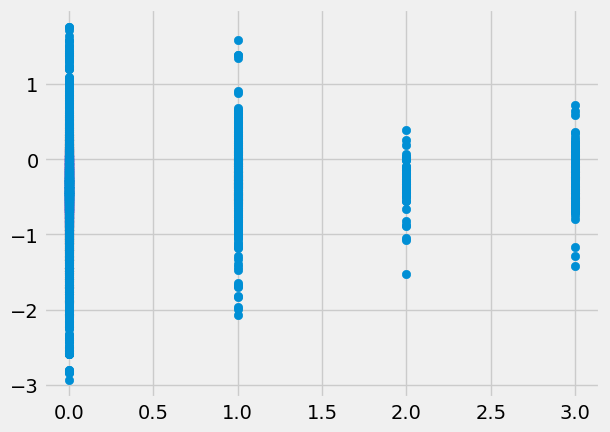

In [20]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [21]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: -0.4438961690899844
Mean predicted score for 1 relevance values: -0.2785778816323083
Mean predicted score for 2 relevance values: -0.30671786277062424
Mean predicted score for 3 relevance values: -0.2551839536009943


In [22]:
column_names = []
for i in [1,12,0,16,8,10,11,3,9,13]:
  column_names.append(X_train_2.columns[i])

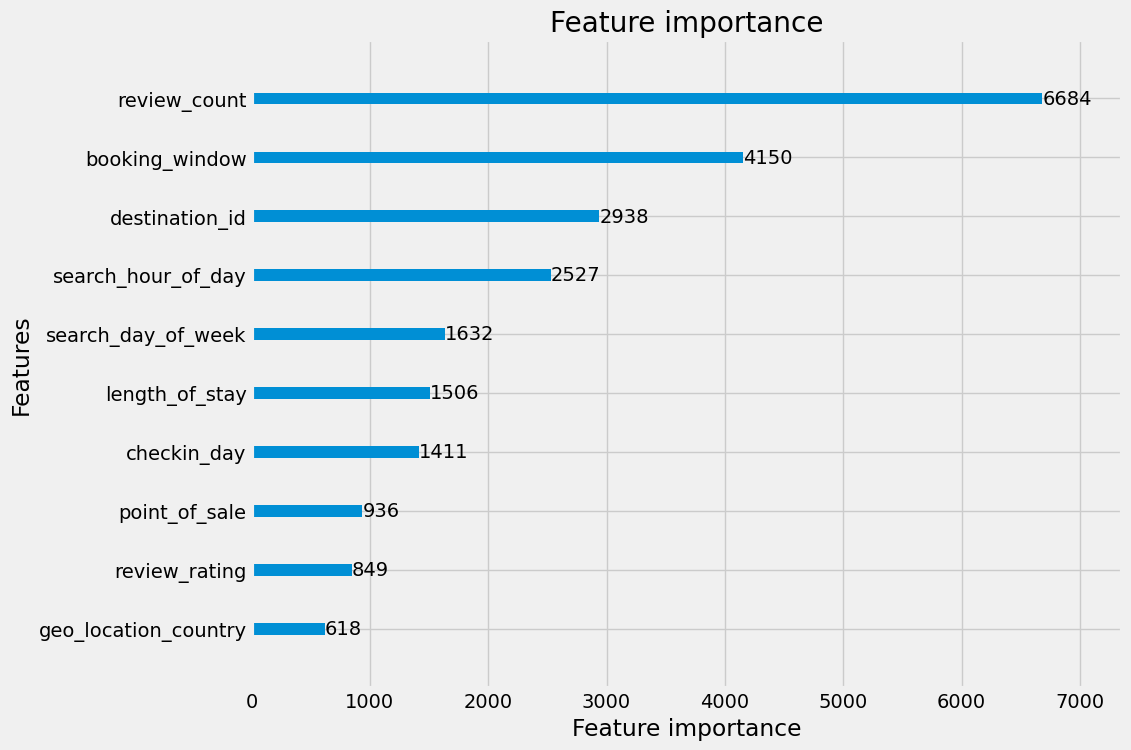

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')
lgb.plot_importance(ranker_model, max_num_features=10, ax=ax)
ax.set_yticklabels(column_names)
plt.show()

In [24]:
test_df['predicted_score'] = test_predictions

<ipython-input-24-40f748f1917c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = test_predictions


In [25]:
ndcg_noad_lgbm_all = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_noad_lgbm_all.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_noad_lgbm_all))

NDCG mean taking into account all values of the ranking 0.459851935380517


In [26]:
ndcg_noad_lgbm_k20 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_noad_lgbm_k20.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_noad_lgbm_k20))

NDCG mean taking into account the first 20 values of the ranking 0.4273271958397317


In [27]:
ndcg_noad_lgbm_k10 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_noad_lgbm_k10.append(ndcg)

print('NDCG mean taking into account the first 10 values of the ranking', np.mean(ndcg_noad_lgbm_k10))

NDCG mean taking into account the first 10 values of the ranking 0.3462132733621273


In [28]:
ndcg_noad_lgbm_k5 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_noad_lgbm_k5.append(ndcg)

print('NDCG mean taking into account the first 5 values of the ranking', np.mean(ndcg_noad_lgbm_k5))

NDCG mean taking into account the first 5 values of the ranking 0.2844546120273676


In [29]:
ndcg_noad_lgbm_k1 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_noad_lgbm_k1.append(ndcg)

print('NDCG mean taking into account the first 1 values of the ranking', np.mean(ndcg_noad_lgbm_k1))

NDCG mean taking into account the first 1 values of the ranking 0.17846924177396278


#Computing NDCG for NOADS Original Dataset

In [30]:
df_noad.head()


,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,checkin_day,checkout_day,relevance
213,23,57,2021-06-03 13:15:00+00:00,1,1,1,41,2021-07-14,2021-07-17,2,0,0,1,RECOMMENDED,3.0,40.0,3,13,1,0,4.0,1050.0,5.0,0,0,5.0,0,0,1.0,2,2,0
216,23,57,2021-06-03 13:15:00+00:00,1,1,1,41,2021-07-14,2021-07-17,2,0,0,1,RECOMMENDED,3.0,40.0,3,13,4,0,4.0,2225.0,4.0,1,1,4.0,0,0,2.0,2,2,0
217,23,57,2021-06-03 13:15:00+00:00,1,1,1,41,2021-07-14,2021-07-17,2,0,0,1,RECOMMENDED,3.0,40.0,3,13,5,0,4.0,875.0,4.0,1,1,5.0,0,0,3.0,2,2,0
218,23,57,2021-06-03 13:15:00+00:00,1,1,1,41,2021-07-14,2021-07-17,2,0,0,1,RECOMMENDED,3.0,40.0,3,13,6,0,5.0,1750.0,5.0,1,1,5.0,0,0,4.0,2,2,0
219,23,57,2021-06-03 13:15:00+00:00,1,1,1,41,2021-07-14,2021-07-17,2,0,0,1,RECOMMENDED,3.0,40.0,3,13,7,0,4.0,1025.0,4.0,1,1,3.0,0,0,5.0,2,2,0


In [31]:
group_counts = df_noad['search_id'].value_counts()
unique_groups = group_counts[group_counts == 1].index
filtered_df = df_noad[~df_noad['search_id'].isin(unique_groups)]

In [32]:
ndcg_df_noads = []
for group_name, group_df in filtered_df.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_df_noads.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_df_noads))

NDCG mean taking into account all values of the ranking 0.6140982240482034


In [33]:
ndcg_df_noads_k20 = []
for group_name, group_df in filtered_df.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_df_noads_k20.append(ndcg)

print('NDCG mean taking into account first 20 values of the ranking', np.mean(ndcg_df_noads_k20))

NDCG mean taking into account first 20 values of the ranking 0.5801268459851266


In [34]:
ndcg_df_noads_k10 = []
for group_name, group_df in filtered_df.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_df_noads_k10.append(ndcg)

print('NDCG mean taking into account first 10 values of the ranking', np.mean(ndcg_df_noads_k10))

NDCG mean taking into account first 10 values of the ranking 0.5183451324636764


In [35]:
ndcg_df_noads_k5 = []
for group_name, group_df in filtered_df.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_df_noads_k5.append(ndcg)

print('NDCG mean taking into account first 5 values of the ranking', np.mean(ndcg_df_noads_k5))

NDCG mean taking into account first 5 values of the ranking 0.4769565651316684


In [36]:
ndcg_df_noads_k1 = []
for group_name, group_df in filtered_df.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_df_noads_k1.append(ndcg)

print('NDCG mean taking into account first of the ranking', np.mean(ndcg_df_noads_k1))

NDCG mean taking into account first of the ranking 0.42646104717933875


## Comparison Original DF vs LightGBM NDCG Scores WITHOUT ADS

In [37]:
df_ndcg = [np.mean(ndcg_df_noads), np.mean(ndcg_df_noads_k20), np.mean(ndcg_df_noads_k10), np.mean(ndcg_df_noads_k5), np.mean(ndcg_df_noads_k1)]
lgbm_ndcg = [np.mean(ndcg_noad_lgbm_all), np.mean(ndcg_noad_lgbm_k20), np.mean(ndcg_noad_lgbm_k10), np.mean(ndcg_noad_lgbm_k5), np.mean(ndcg_noad_lgbm_k1)]
results_df = pd.DataFrame({"Ks":['All', 'K20', 'K10', 'K5', 'K1'],'Dataframe_ndcg':df_ndcg, 'LGBM_ndcg': lgbm_ndcg})

In [38]:
results_df

,Ks,Dataframe_ndcg,LGBM_ndcg
0,All,0.614098,0.459852
1,K20,0.580127,0.427327
2,K10,0.518345,0.346213
3,K5,0.476957,0.284455
4,K1,0.426461,0.178469


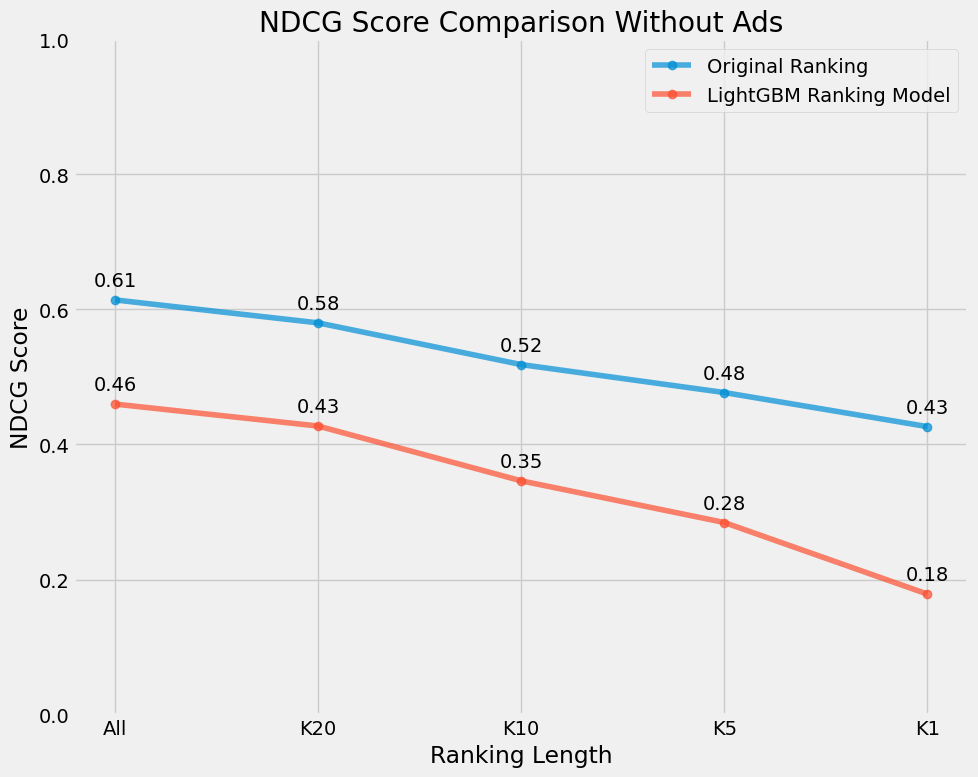

In [39]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10,8))

plt.plot(results_df["Ks"], results_df['Dataframe_ndcg'], marker='o', label='Original Ranking', alpha=0.7)
plt.plot(results_df["Ks"], results_df['LGBM_ndcg'], marker='o', label='LightGBM Ranking Model', alpha=0.7)

plt.legend()

for x, y in zip(results_df["Ks"], results_df['Dataframe_ndcg']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

for x, y in zip(results_df["Ks"], results_df['LGBM_ndcg']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Ranking Length')
plt.ylabel('NDCG Score')
plt.title('NDCG Score Comparison Without Ads')

plt.ylim(0,1)

plt.tight_layout()
plt.show()

## PLOT COMPARISON WITH AND WITHOUT ADS

In [42]:
df_ndcg_noads = [np.mean(ndcg_df_noads), np.mean(ndcg_df_noads_k20), np.mean(ndcg_df_noads_k10), np.mean(ndcg_df_noads_k5), np.mean(ndcg_df_noads_k1)]
lgbm_ndcg_noads = [np.mean(ndcg_noad_lgbm_all), np.mean(ndcg_noad_lgbm_k20), np.mean(ndcg_noad_lgbm_k10), np.mean(ndcg_noad_lgbm_k5), np.mean(ndcg_noad_lgbm_k1)]

df_ndcg_ads = [0.624,0.582,0.528,0.491,0.442]
lgbm_ndcg_ads = [0.459,0.42,0.345,0.275,0.181]

results_df = pd.DataFrame({"Ks":['All', 'K20', 'K10', 'K5', 'K1'],'df_ndcg_ads':df_ndcg_ads, 'lgbm_ndcg_ads': lgbm_ndcg_ads, 'df_ndcg_noads':df_ndcg_noads, 'lgbm_ndcg_noads':lgbm_ndcg_noads})

results_df

,Ks,df_ndcg_ads,lgbm_ndcg_ads,df_ndcg_noads,lgbm_ndcg_noads
0,All,0.624,0.459,0.614098,0.459852
1,K20,0.582,0.420,0.580127,0.427327
2,K10,0.528,0.345,0.518345,0.346213
3,K5,0.491,0.275,0.476957,0.284455
4,K1,0.442,0.181,0.426461,0.178469


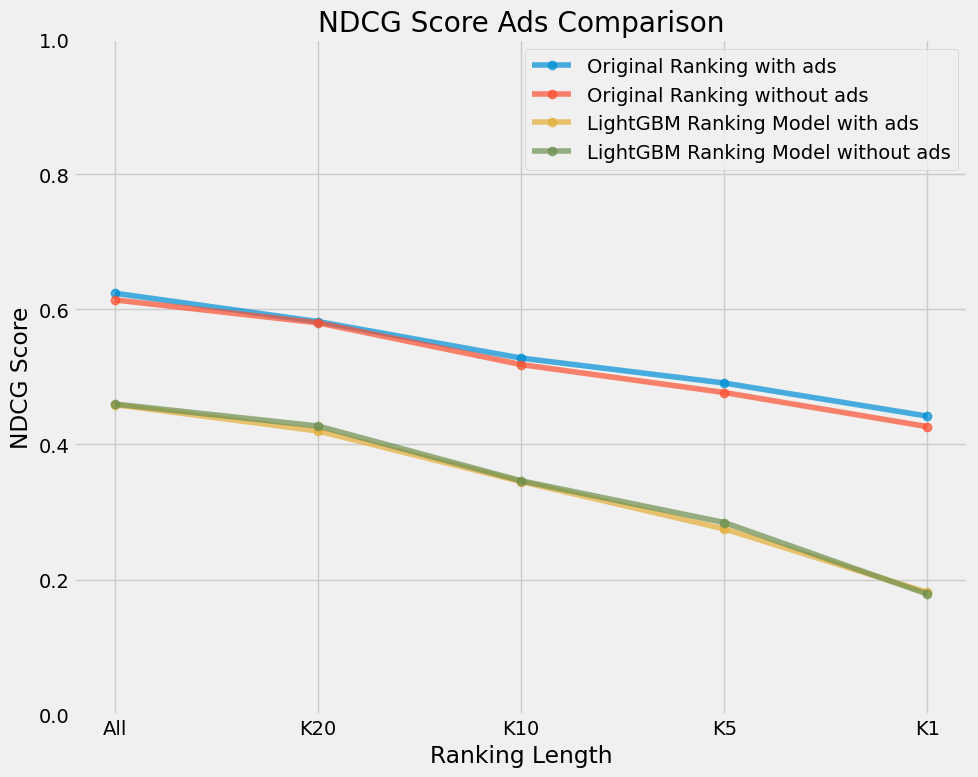

In [51]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10,8))

plt.plot(results_df["Ks"], results_df['df_ndcg_ads'], marker='o', label='Original Ranking with ads', alpha=0.7)
plt.plot(results_df["Ks"], results_df['df_ndcg_noads'], marker='o', label='Original Ranking without ads', alpha=0.7)

plt.plot(results_df["Ks"], results_df['lgbm_ndcg_ads'], marker='o', label='LightGBM Ranking Model with ads', alpha=0.7)
plt.plot(results_df["Ks"], results_df['lgbm_ndcg_noads'], marker='o', label='LightGBM Ranking Model without ads', alpha=0.7)

plt.legend()
'''
for x, y in zip(results_df["Ks"], results_df['df_ndcg_ads']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

for x, y in zip(results_df["Ks"], results_df['df_ndcg_noads']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
'''

plt.xlabel('Ranking Length')
plt.ylabel('NDCG Score')
plt.title('NDCG Score Ads Comparison')

plt.ylim(0,1)

plt.tight_layout()
plt.show()

## Comparison Categorical-Numeric Variables

In [52]:
df = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/exploded_df_top50dest_searched_100Krows.parquet')

In [54]:
df_m = df.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

no_s_id = df_m[df_m['num_clicks'] != 0]['search_id'].tolist()

df = df[df['search_id'].isin(no_s_id)]
df.shape

(80386, 29)

In [55]:
df['review_count'] = df['review_count'].fillna(0)

In [56]:
df['star_rating'] = df['star_rating'].astype('category')
df['star_rating'] = df['star_rating'].cat.add_categories('Not Available')
df['star_rating'] = df['star_rating'].fillna('Not Available')

In [57]:
df['review_rating'] = df['review_rating'].astype('category')
df['review_rating'] = df['review_rating'].cat.add_categories('Not Available')
df['review_rating'] = df['review_rating'].fillna('Not Available')

In [58]:
df['price_bucket'] = df['price_bucket'].astype('category')
df['price_bucket'] = df['price_bucket'].cat.add_categories('Not Available')
df['price_bucket'] = df['price_bucket'].fillna('Not Available')

In [59]:
df['is_mobile'] = df['is_mobile'].astype('category')
df['destination_id'] = df['destination_id'].astype('category')
df['sort_type'] = df['sort_type'].astype('category')
df['search_day_of_week'] = df['search_day_of_week'].astype('category')
df['is_travel_ad'] = df['is_travel_ad'].astype('category')
df['is_free_cancellation'] = df['is_free_cancellation'].astype('category')
df['is_drr'] = df['is_drr'].astype('category')

In [60]:
df2=df.copy()

In [61]:
#Assigning +1 per each click and +2 per booking, having as max value 3
df2['relevance'] = df2['num_clicks'] + 2 * df2['is_trans']
df2.loc[df2['relevance'] > 3, 'relevance'] = 3
df2['relevance'].value_counts()

relevance
0    75351
1     4301
3      441
2      293
Name: count, dtype: int64

In [62]:
def split_by_qid(df2, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df2['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df2[df2['search_id'].isin(ids[train_idx])], df2[df2['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df2, test_size=0.3)

train_df.shape, test_df.shape

((56325, 30), (24061, 30))

In [63]:
train_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks'], inplace=True)
test_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks'], inplace=True)

train_df.shape, test_df.shape

<ipython-input-63-6746e865c970>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks'], inplace=True)
<ipython-input-63-6746e865c970>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks'], inplace=True)


((56325, 23), (24061, 23))

In [64]:
X_train = train_df.drop(columns=['relevance'])
y_train = train_df['relevance']

X_test = test_df.drop(columns=['relevance'])
y_test = test_df['relevance']

query_id_train = X_train['search_id']

query_id_test = X_test['search_id']

categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['category']).columns.tolist()

numeric_features.remove('search_id')

categorical_features, numeric_features

(['is_mobile',
  'destination_id',
  'sort_type',
  'search_day_of_week',
  'is_travel_ad',
  'review_rating',
  'star_rating',
  'is_free_cancellation',
  'is_drr',
  'price_bucket'],
 ['point_of_sale',
  'geo_location_country',
  'adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'search_hour_of_day',
  'review_count',
  'is_trans'])

['sort_type', 'star_rating', 'price_bucket']

In [65]:
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

X_train.shape, X_test.shape

((56325, 103), (24061, 103))

In [66]:
X_train_2 = X_train.drop(columns=['search_id'])
X_train_2.head()

,point_of_sale,geo_location_country,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,search_hour_of_day,review_count,is_trans,is_mobile_0,is_mobile_1,destination_id_2,destination_id_3,destination_id_4,destination_id_5,destination_id_6,destination_id_7,destination_id_8,destination_id_9,destination_id_10,destination_id_11,destination_id_12,destination_id_13,destination_id_14,destination_id_15,destination_id_16,destination_id_17,destination_id_19,destination_id_20,destination_id_21,destination_id_22,destination_id_23,destination_id_24,destination_id_25,destination_id_26,destination_id_28,destination_id_29,destination_id_36,destination_id_37,destination_id_40,destination_id_42,destination_id_43,destination_id_44,destination_id_48,destination_id_49,destination_id_51,destination_id_58,destination_id_59,destination_id_60,destination_id_61,destination_id_69,destination_id_72,destination_id_78,destination_id_81,destination_id_83,destination_id_86,destination_id_92,destination_id_102,destination_id_106,destination_id_202,destination_id_344,sort_type_DEALS,sort_type_GUEST RATINGS DESCENDING,sort_type_PRICE ASCENDING,sort_type_RECOMMENDED,sort_type_SPECIAL - DIRECT HOTEL SEARCH,sort_type_STAR RATING DESCENDING,sort_type_VACATION RENTAL,search_day_of_week_0,search_day_of_week_1,search_day_of_week_2,search_day_of_week_3,search_day_of_week_4,search_day_of_week_5,search_day_of_week_6,is_travel_ad_0,is_travel_ad_1,review_rating_0.0,review_rating_1.0,review_rating_2.0,review_rating_3.0,review_rating_4.0,review_rating_5.0,review_rating_Not Available,star_rating_1.0,star_rating_2.0,star_rating_3.0,star_rating_4.0,star_rating_5.0,star_rating_Not Available,is_free_cancellation_0,is_free_cancellation_1,is_drr_0,is_drr_1,price_bucket_1.0,price_bucket_2.0,price_bucket_3.0,price_bucket_4.0,price_bucket_5.0,price_bucket_Not Available
0,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,-0.211706,-0.068099,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False
1,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,-0.275403,-0.068099,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,False
2,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,-0.176320,-0.068099,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False
3,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,0.064311,-0.068099,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [67]:
import lightgbm as lgb

X_train_arr = X_train_2.values
y_train_array = y_train.values.ravel()

query_group_sizes_train = []
for i in X_train['search_id'].value_counts():
  query_group_sizes_train.append(i)

query_group_sizes_train_arr = np.array(query_group_sizes_train)

# Define LightGBM parameters for ranker
params = {
    'objective': 'lambdarank',  # Ranking objective
    'metric': 'ndcg',  # Evaluation metric
    'learning_rate': 0.01,
    'verbose': 0
}

train_data = lgb.Dataset(X_train_arr, label=y_train_array, group=query_group_sizes_train_arr)

num_rounds = 1000
ranker_model = lgb.train(params, train_data, num_rounds)

In [68]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values

y_test_array = y_test.values.ravel()

query_group_sizes_test = []
for i in X_test['search_id'].value_counts():
  query_group_sizes_test.append(i)
query_group_sizes_test_arr = np.array(query_group_sizes_test)

test_data = lgb.Dataset(X_test_arr, label=y_test_array, group=query_group_sizes_test_arr, reference=train_data)

In [69]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': test_predictions})
y_test_df.head()

,relevance_score,predicted_ranking
540,0,-0.695334
541,0,-0.349639
542,0,-0.258974
543,1,0.301454
544,1,-0.608369


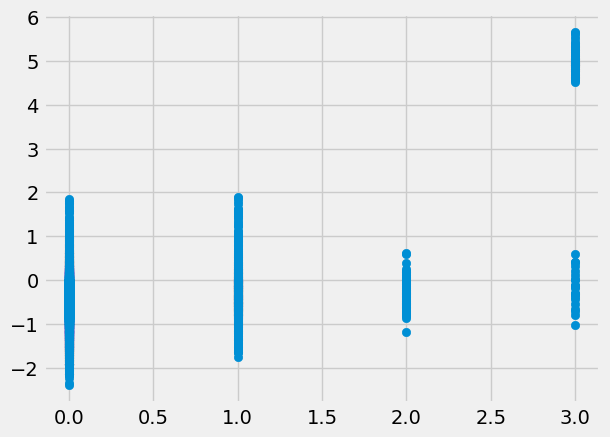

In [70]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [71]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: -0.482902606804302
Mean predicted score for 1 relevance values: -0.2770321745745861
Mean predicted score for 2 relevance values: -0.27448913184384005
Mean predicted score for 3 relevance values: 4.1624952579601535


In [72]:
test_df['predicted_score'] = test_predictions
test_df.shape

<ipython-input-72-d97ebf8bfbaa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = test_predictions


(24061, 24)

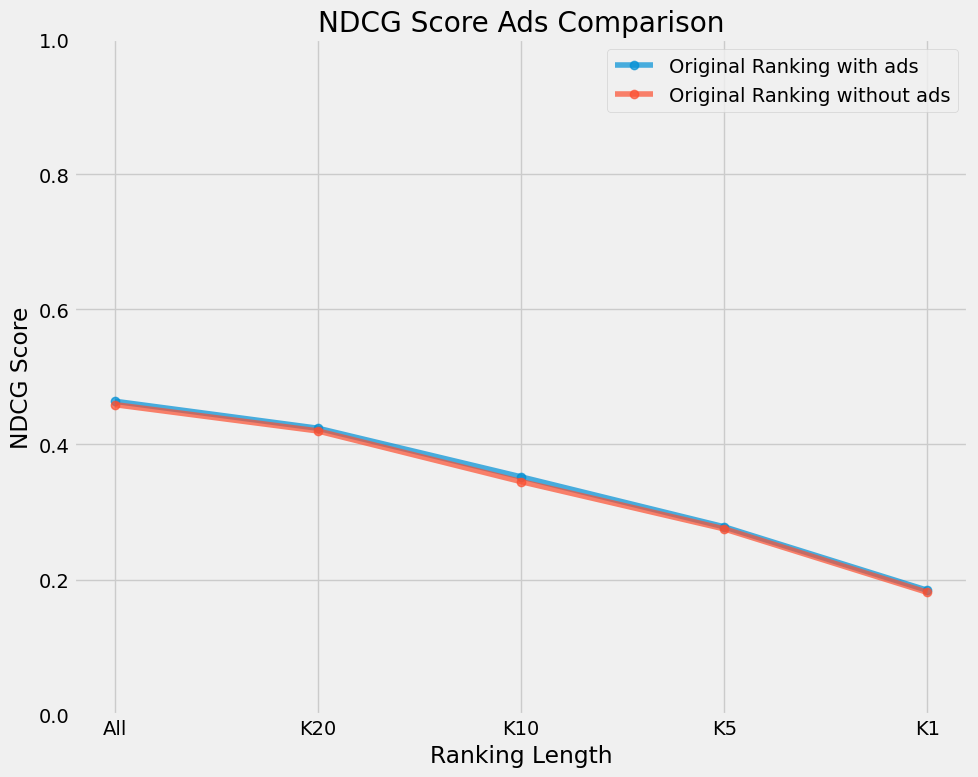

In [78]:
g = [0.464, 0.424, 0.352, 0.278, 0.184]
k = [0.459,0.42,0.345,0.275,0.181]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(10,8))

plt.plot(['All', 'K20', 'K10', 'K5', 'K1'], g, marker='o', label='Original Ranking with ads', alpha=0.7)
plt.plot(['All', 'K20', 'K10', 'K5', 'K1'], k, marker='o', label='Original Ranking without ads', alpha=0.7)


plt.legend()
'''
for x, y in zip(results_df["Ks"], results_df['df_ndcg_ads']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

for x, y in zip(results_df["Ks"], results_df['df_ndcg_noads']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
'''

plt.xlabel('Ranking Length')
plt.ylabel('NDCG Score')
plt.title('NDCG Score Ads Comparison')

plt.ylim(0,1)

plt.tight_layout()
plt.show()

## LGBM with Amenities

In [5]:
df_amenities = pd.read_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_Top500Destinations__LeftJoin_Amenities_NaHandled_17April.csv')

In [6]:
df_amenities.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,checkin_day,checkout_day,rank,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
0,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,1,1624072,0,4.0,1250.0,4.0,1,1,2.0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,2,5170759,1,4.0,1025.0,3.0,0,0,1.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,3,1342604,1,4.0,1375.0,4.0,1,1,4.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,4,5866319,0,4.0,2225.0,4.0,1,1,1.0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,5,2935403,0,5.0,1050.0,4.0,1,1,2.0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_amenities.shape

(209981, 49)

In [8]:
#Assigning +1 per each click and +2 per booking, having as max value 3
df_amenities['relevance'] = df_amenities['num_clicks'] + 2 * df_amenities['is_trans']
df_amenities.loc[df_amenities['relevance'] > 3, 'relevance'] = 3
df_amenities['relevance'].value_counts()

relevance
0    195442
1     12359
3      1178
2      1002
Name: count, dtype: int64

In [9]:
def split_by_qid(df2, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df2['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df2[df2['search_id'].isin(ids[train_idx])], df2[df2['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df_amenities, test_size=0.2)

train_df.shape, test_df.shape

((168127, 50), (41854, 50))

In [10]:
train_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)
test_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)

train_df.shape, test_df.shape

<ipython-input-10-0895702919e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)
<ipython-input-10-0895702919e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)


((168127, 42), (41854, 42))

In [11]:
X_train_t = train_df.drop(columns=['relevance'])
y_train = train_df['relevance']

X_test_t = test_df.drop(columns=['relevance'])
y_test = test_df['relevance']

query_id_train = X_train_t['search_id']

query_id_test = X_test_t['search_id']

In [12]:
X_train_t.columns

Index(['search_id', 'point_of_sale', 'geo_location_country', 'is_mobile',
       'destination_id', 'adult_count', 'child_count', 'infant_count',
       'room_count', 'sort_type', 'length_of_stay', 'booking_window',
       'search_day_of_week', 'search_hour_of_day', 'checkin_day',
       'checkout_day', 'is_travel_ad', 'review_rating', 'review_count',
       'star_rating', 'is_free_cancellation', 'is_drr', 'price_bucket',
       'AirConditioning', 'AirportTransfer', 'Bar',
       'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
       'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking',
       'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool',
       'WasherDryer', 'WiFi'],
      dtype='object')

In [13]:

object_col = ['point_of_sale', 'geo_location_country', 'is_mobile', 'destination_id','sort_type', 'search_day_of_week','search_hour_of_day', 'checkin_day', 'checkout_day', 'is_travel_ad',
              'review_rating','review_count','star_rating','is_free_cancellation', 'is_drr', 'AirConditioning', 'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
              'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool', 'SpaServices', 'WasherDryer', 'WiFi']

for i in object_col:
  X_train_t[i]=X_train_t[i].astype('object')



In [14]:

object_col = ['point_of_sale', 'geo_location_country', 'is_mobile', 'destination_id','sort_type', 'search_day_of_week','search_hour_of_day', 'checkin_day', 'checkout_day', 'is_travel_ad',
              'review_rating','review_count', 'star_rating','is_free_cancellation', 'is_drr', 'AirConditioning', 'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
              'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool', 'SpaServices', 'WasherDryer', 'WiFi']

for i in object_col:
  X_test_t[i]=X_test_t[i].astype('object')


In [15]:
X_train_t.shape, X_test_t.shape

((168127, 41), (41854, 41))

In [16]:
X_test_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41854 entries, 0 to 209812
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   search_id                  41854 non-null  int64  
 1   point_of_sale              41854 non-null  object 
 2   geo_location_country       41854 non-null  object 
 3   is_mobile                  41854 non-null  object 
 4   destination_id             41854 non-null  object 
 5   adult_count                41854 non-null  int64  
 6   child_count                41854 non-null  int64  
 7   infant_count               41854 non-null  int64  
 8   room_count                 41854 non-null  int64  
 9   sort_type                  41854 non-null  object 
 10  length_of_stay             41854 non-null  float64
 11  booking_window             41854 non-null  float64
 12  search_day_of_week         41854 non-null  object 
 13  search_hour_of_day         41854 non-null  object 

In [17]:
categorical_features = X_train_t.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_t.select_dtypes(exclude=['object']).columns.tolist()

numeric_features.remove('search_id')

categorical_features, numeric_features

(['point_of_sale',
  'geo_location_country',
  'is_mobile',
  'destination_id',
  'sort_type',
  'search_day_of_week',
  'search_hour_of_day',
  'checkin_day',
  'checkout_day',
  'is_travel_ad',
  'review_rating',
  'review_count',
  'star_rating',
  'is_free_cancellation',
  'is_drr',
  'AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi'],
 ['adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'price_bucket'])

In [18]:
combined_df = pd.concat([X_train_t, X_test_t])
combined_df = pd.get_dummies(combined_df, columns=categorical_features)

In [19]:
combined_df.shape

(209981, 1456)

In [20]:
X_train = combined_df[:len(X_train_t)]
X_test = combined_df[len(X_train_t):]

X_train.shape, X_test.shape

((168127, 1456), (41854, 1456))

In [21]:
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

<ipython-input-21-14c6cb60ee79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
<ipython-input-21-14c6cb60ee79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = scaler.transform(X_test[numeric_features])


In [22]:
X_train.shape, X_test.shape

((168127, 1456), (41854, 1456))

In [23]:
X_train_2 = X_train.drop(columns=['search_id'])

In [24]:
X_train_arr = X_train_2.values

y_train_array = y_train.values.ravel()

In [25]:
import lightgbm as lgb

query_group_sizes_train = []
for i in X_train['search_id'].value_counts():
  query_group_sizes_train.append(i)

query_group_sizes_train_arr = np.array(query_group_sizes_train)

# Define LightGBM parameters for ranker
params = {
    'objective': 'lambdarank',  # Ranking objective
    'metric': 'ndcg',  # Evaluation metric
    'learning_rate': 0.01,
    'verbose': 0
}

train_data = lgb.Dataset(X_train_arr, label=y_train_array, group=query_group_sizes_train_arr)

num_rounds = 50
ranker_model = lgb.train(params, train_data, num_rounds)

In [26]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values

y_test_array = y_test.values.ravel()

query_group_sizes_test = []
for i in X_test['search_id'].value_counts():
  query_group_sizes_test.append(i)
query_group_sizes_test_arr = np.array(query_group_sizes_test)

test_data = lgb.Dataset(X_test_arr, label=y_test_array, group=query_group_sizes_test_arr, reference=train_data)

In [27]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': test_predictions})
y_test_df.head()

,relevance_score,predicted_ranking
0,1,-0.034592
1,0,0.031296
2,0,-0.002553
3,0,-0.012982
4,0,-0.005859


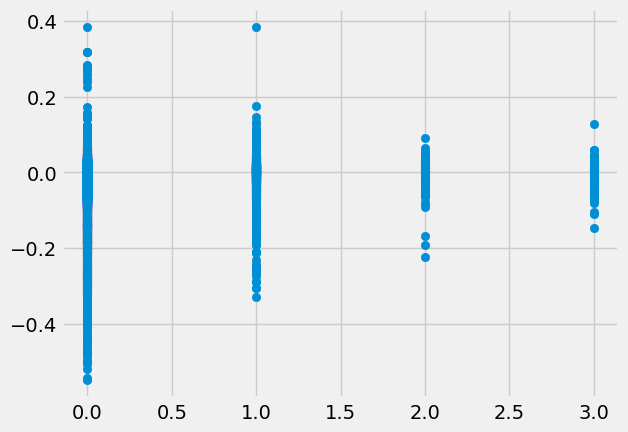

In [28]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [29]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: -0.024207028740182292
Mean predicted score for 1 relevance values: -0.007617146101831142
Mean predicted score for 2 relevance values: -0.0007845867832621311
Mean predicted score for 3 relevance values: -0.003993703157338712


In [32]:
column_names = []
for i in [691,693,700,1329,1423,4,1447,608,5,6]:
  column_names.append(X_train_2.columns[i])

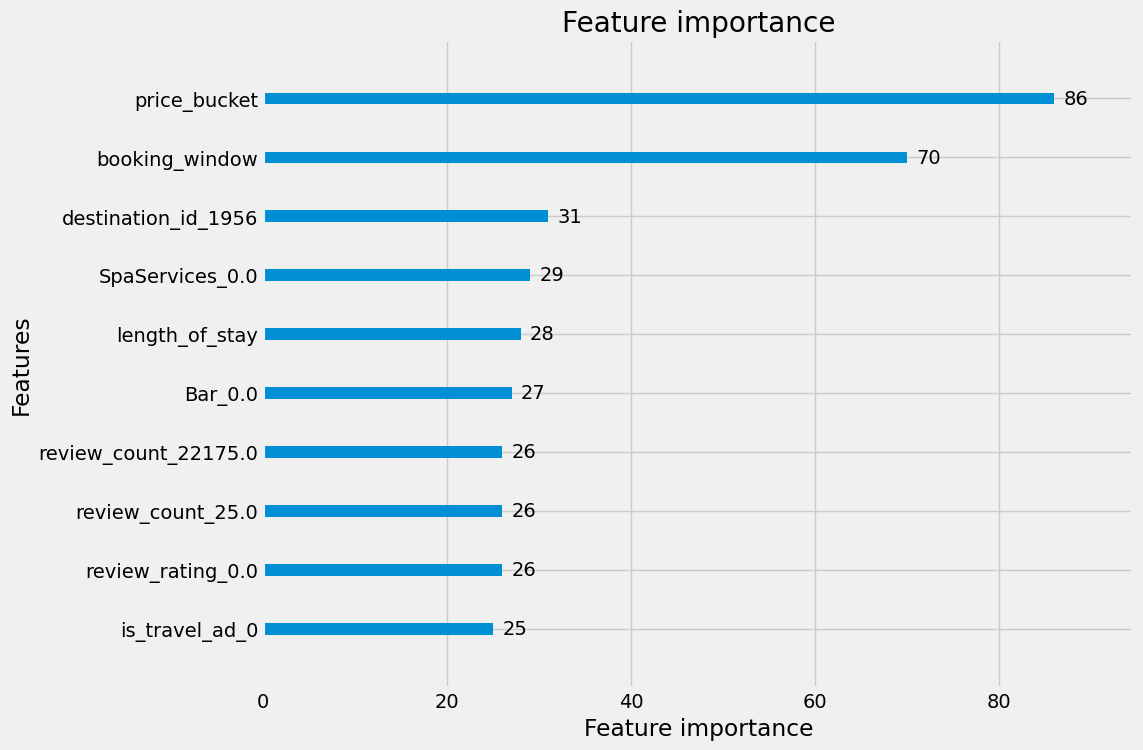

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')
lgb.plot_importance(ranker_model, max_num_features=10, ax=ax)
ax.set_yticklabels(column_names)
plt.show()

In [35]:
test_df['predicted_score'] = test_predictions

<ipython-input-35-40f748f1917c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = test_predictions


In [36]:
ndcg_noad_lgbm_all = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_noad_lgbm_all.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_noad_lgbm_all))

NDCG mean taking into account all values of the ranking 0.47092261487169684


In [37]:
ndcg_noad_lgbm_k20 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_noad_lgbm_k20.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_noad_lgbm_k20))

NDCG mean taking into account the first 20 values of the ranking 0.4359261833105734


In [38]:
ndcg_noad_lgbm_k10 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_noad_lgbm_k10.append(ndcg)

print('NDCG mean taking into account the first 10 values of the ranking', np.mean(ndcg_noad_lgbm_k10))

NDCG mean taking into account the first 10 values of the ranking 0.3591645400544806


In [39]:
ndcg_noad_lgbm_k5 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_noad_lgbm_k5.append(ndcg)

print('NDCG mean taking into account the first 5 values of the ranking', np.mean(ndcg_noad_lgbm_k5))

NDCG mean taking into account the first 5 values of the ranking 0.2854237181073548


In [40]:
ndcg_noad_lgbm_k1 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_noad_lgbm_k1.append(ndcg)

print('NDCG mean taking into account the first 1 values of the ranking', np.mean(ndcg_noad_lgbm_k1))

NDCG mean taking into account the first 1 values of the ranking 0.1834625322997416


## NEURAL NETWORK

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [42]:
loss_fn_mse = 'mse'  # Mean Squared Error as a baseline loss function
loss_fn_ranknet = tf.losses.BinaryCrossentropy(from_logits=True)
loss_fn_listnet = tf.losses.CategoricalCrossentropy(from_logits=True)

In [43]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# Define the architecture of the neural network
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_arr.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer with linear activation for ranking scores
])

# Choose an appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn_mse)

X_train_2 = X_train.drop(columns=['search_id'])
X_train_arr = X_train_2.values
y_train_array = y_train.values.ravel()

# Train the model
history = model.fit(X_train_arr, y_train_array,
                    epochs=30, validation_split=0.2,
                    verbose=True, callbacks=[early_stopping_cb])  # Using validation split
history

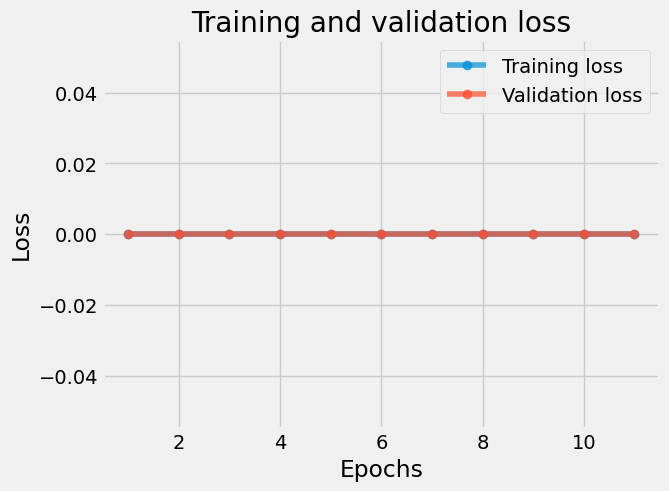

In [269]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, label='Training loss', marker='o', alpha=0.7)
plt.plot(epochs, val_loss, label='Validation loss', marker='o', alpha=0.7)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [270]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values
y_test_array = y_test.values.ravel()

test_loss = model.evaluate(X_test_arr, y_test_array)

477/477 [==============================] - 1s 2ms/step - loss: 0.0000e+00


In [271]:
predictions = model.predict(X_test_arr.astype(float))

477/477 [==============================] - 1s 2ms/step


In [272]:
predictions = predictions.reshape(-1)

In [273]:
y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': predictions})
y_test_df.head()

,relevance_score,predicted_ranking
4,0,-1.469238e+12
7,0,-9.978602e+11
8,0,-7.266273e+11
24,0,-2.903623e+12
25,0,-3.569722e+11


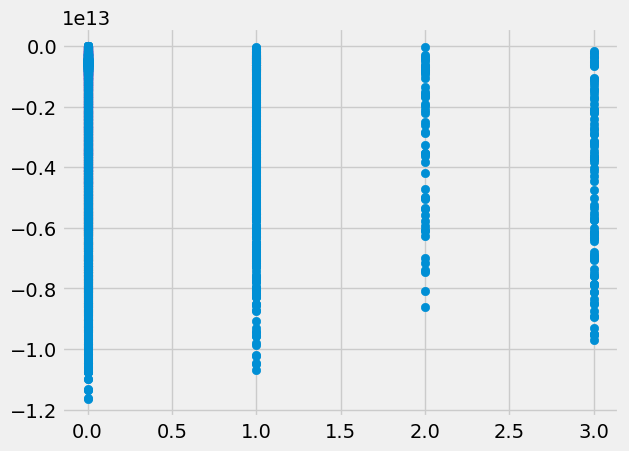

In [274]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [275]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: -2709504000000.0
Mean predicted score for 1 relevance values: -2822329000000.0
Mean predicted score for 2 relevance values: -3280133700000.0
Mean predicted score for 3 relevance values: -4503394000000.0


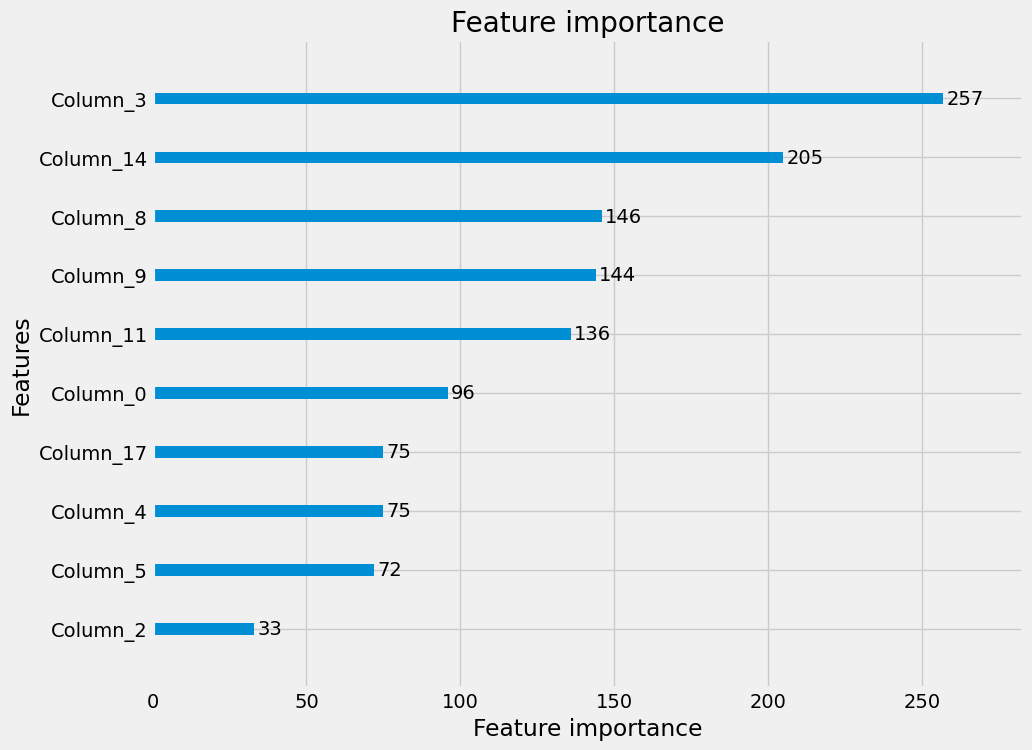

In [276]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')
lgb.plot_importance(ranker_model, max_num_features=10, ax=ax)
#ax.set_yticklabels(column_names)
plt.show()

In [277]:
column_names = []
for i in [2,5,4,17,0,11,9,8,14,3]:
  column_names.append(X_train_2.columns[i])

In [278]:
test_df['predicted_score'] = predictions

<ipython-input-278-46e2002cb8da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = predictions


In [279]:
ndcg_noad_nn_all = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_noad_nn_all.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_noad_nn_all))

NDCG mean taking into account all values of the ranking 0.32800980972890226


In [280]:
ndcg_noad_nn_k20 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_noad_nn_k20.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_noad_nn_k20))

NDCG mean taking into account the first 20 values of the ranking 0.231255579918519


In [281]:
ndcg_noad_nn_k10 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_noad_nn_k10.append(ndcg)

print('NDCG mean taking into account the first 10 values of the ranking', np.mean(ndcg_noad_nn_k10))

NDCG mean taking into account the first 10 values of the ranking 0.1394504083483765


In [282]:
ndcg_noad_nn_k5 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_noad_nn_k5.append(ndcg)

print('NDCG mean taking into account the first 5 values of the ranking', np.mean(ndcg_noad_nn_k5))

NDCG mean taking into account the first 5 values of the ranking 0.09705439119668519


In [283]:
ndcg_noad_nn_k1 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_noad_nn_k1.append(ndcg)

print('NDCG mean taking into account the first 1 values of the ranking', np.mean(ndcg_noad_nn_k1))

NDCG mean taking into account the first 1 values of the ranking 0.04452690166975881


In [284]:
nn_mseloss = [0.367, 0.308, 0.21, 0.135,0.074]
nn_ranknetloss = [0.366, 0.298, 0.207, 0.146, 0.083]
nn_listnetloss = [0.328, 0.231, 0.139, 0.097, 0.044]
ks = ['All', 'K20', 'K10', 'K5', 'K1']

loss_df = pd.DataFrame({'ranking': ks, 'mse_loss':nn_mseloss, 'ranknet_loss':nn_ranknetloss, 'listnet_loss':nn_listnetloss})

In [285]:
loss_df

,ranking,mse_loss,ranknet_loss,listnet_loss
0,All,0.367,0.366,0.328
1,K20,0.308,0.298,0.231
2,K10,0.210,0.207,0.139
3,K5,0.135,0.146,0.097
4,K1,0.074,0.083,0.044


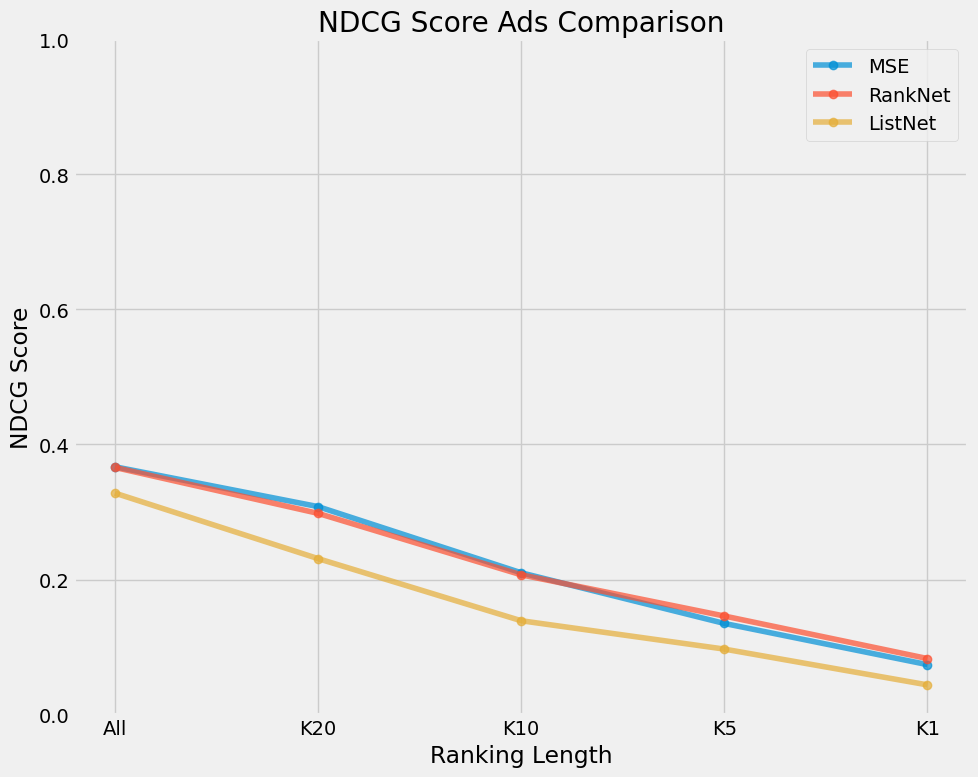

In [288]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10,8))

plt.plot(loss_df['ranking'], loss_df['mse_loss'], marker='o', label='MSE', alpha=0.7)
plt.plot(loss_df['ranking'], loss_df['ranknet_loss'], marker='o', label='RankNet', alpha=0.7)
plt.plot(loss_df['ranking'], loss_df['listnet_loss'], marker='o', label='ListNet', alpha=0.7)

plt.legend()

plt.xlabel('Ranking Length')
plt.ylabel('NDCG Score')
plt.title('NDCG Score Ads Comparison')

plt.ylim(0,1)

plt.tight_layout()
plt.show()